# Sentiment Classification of Clothing Reviews💃👘👗 [WIP]
![Clothes](https://images.unsplash.com/photo-1521335629791-ce4aec67dd15?ixlib=rb-0.3.5&ixid=eyJhcHBfaWQiOjEyMDd9&s=aa5acd64bf664bc9de6f22d03f6d9c91&auto=format&fit=crop&w=1350&q=80)


# Introduction

The goal is to gather sentiment from reviews for clothes from shopping reviews. I will be using the Fast.ai library to achieve this. The dataset is [Womens Ecommerce Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) which has 23 000 customer reviews and ratings.  

I will do some light EDA to make sense of the data. I will also do the basic NLP preparation techniques like tokenaztion with spacy. 


# Resources Used

* [fast.ai](http://https://github.com/fastai/fastai/blob/master/courses/dl1/lesson4-imdb.ipynb)
* [How to interpert the 'perplexed' metric](https://www.quora.com/What-is-perplexity-in-NLP)
* [Pytorch Docs](https://torchtext.readthedocs.io/en/latest/data.html#)
* [Datacamp](https://github.com/AmoDinho/datacamp-python-data-science-track/blob/master/Cleaning%20Data%20in%20Python/Chapter%205%20-%20Case%20study.py)


# Table of Contents

1. Load Data 
2. EDA
3. Natural Language Processing
4. Build The Model
5. Determine Sentiment  [NB remember to build your own torch text dataset]

# 1. Load Data

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle
import spacy

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import seaborn as sns
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))



['Womens Clothing E-Commerce Reviews.csv']


In [3]:
PATH = "../input/Womens Clothing E-Commerce Reviews.csv"

PATH_WRITE = '/kaggle/working/'
TMP_PATH = '/kaggle/working/tmp/'
MODELS_PATH = '/kaggle/working/models/'

%mkdir -p {MODELS_PATH}
%mkdir -p {TMP_PATH}

In [4]:
reviews = pd.read_csv("../input/Womens Clothing E-Commerce Reviews.csv")

In [ ]:
reviews.head()

In [ ]:
reviews.info()

In [ ]:
reviews.describe()

# 2. EDA 
 Univariavte Analysis






/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


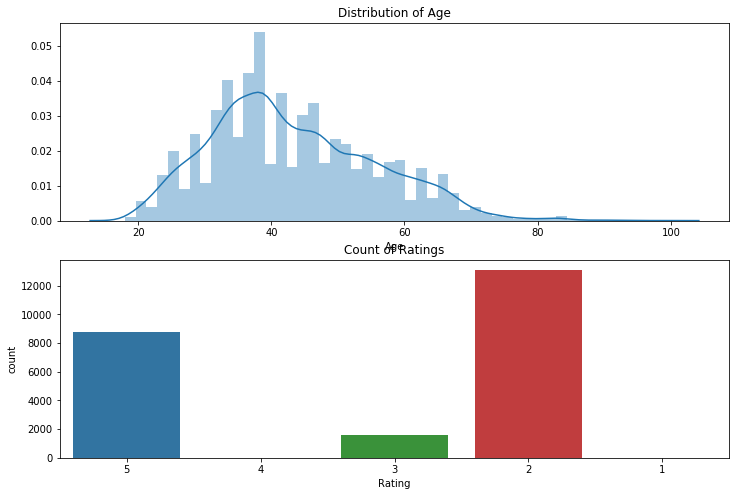

In [5]:
fig, axarr = plt.subplots(2,1,figsize=(12,8))

sns.distplot(reviews['Age'],ax=axarr[0])
sns.countplot(x=reviews['Rating'],data=reviews['Rating'], order=reviews['Rating'].value_counts().index, ax=axarr[1])
axarr[0].set_title("Distribution of Age")
axarr[1].set_title("Count of Ratings")
plt.show()

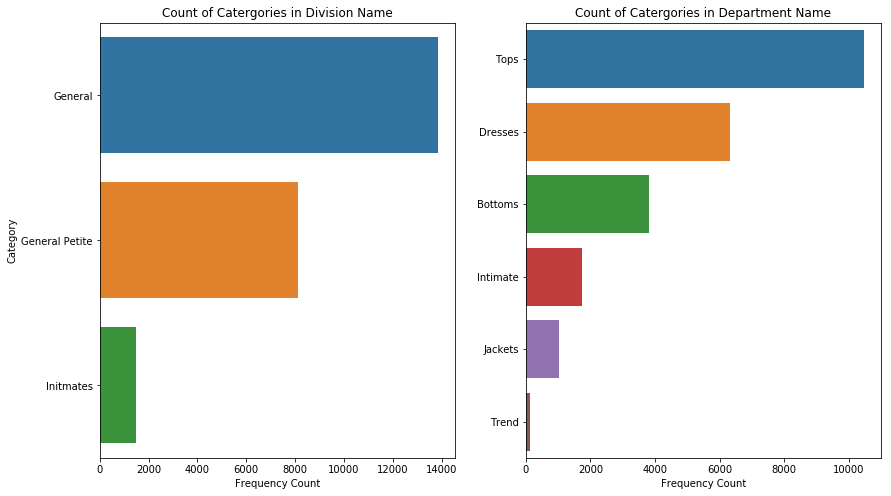

In [8]:
plots = ["Division Name", "Department Name"]
fig, axarr = plt.subplots(1,len(plots),figsize=(14,8))


for i,x in enumerate(plots):
     sns.countplot(y=x,data=reviews, order=reviews[x].value_counts().index, ax=axarr[i])
     axarr[i].set_title("Count of Catergories in {}".format(x))
     
axarr[0].set_ylabel("Category")
axarr[1].set_ylabel("")
axarr[0].set_xlabel("Frequency Count")
axarr[1].set_xlabel("Frequency Count")
plt.show()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

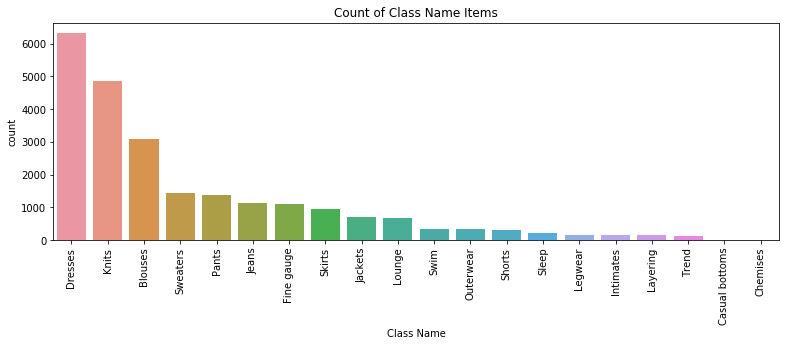

In [9]:
plt.figure(figsize=(13,4))
sns.countplot(reviews["Class Name"], order=reviews["Class Name"].value_counts().index)
plt.title("Count of Class Name Items")
plt.xticks(rotation=90)

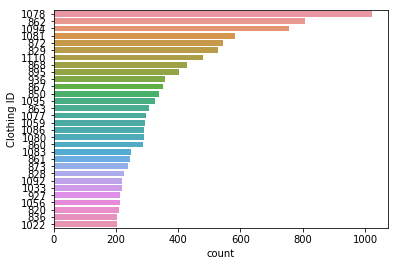

<Figure size 1008x504 with 0 Axes>

In [10]:
sns.countplot(y="Clothing ID", data=reviews[reviews["Clothing ID"].isin(reviews["Clothing ID"].value_counts()[:30].index)], 
              
              order=reviews["Clothing ID"].value_counts()[:30].index)
plt.figure(figsize=(14,7))
plt.show()

Questions to explore for multivariate analysis: 

* Count the positive vs negative ratings
* Can we find the which age give the most ratings on a particular item of clothing?
* What kind of ratings to different age groups give?
* Which item of clothing has the highest rating?

# 3. Natural Language Processing


We are only interested in the review text and rating columns, so we will go ahead and extract that from the `reviews` dataset.

In [ ]:
review_text = reviews[['Review Text', 'Rating']]
review_text.head()

In [ ]:
review_text.shape

In [ ]:
review_text.describe()

Lets do some cleaning up of the data:

In [ ]:
len(review_text.isnull())

`isnull()` checks if there are null values in a dataframe and returns a boolean value. In this case we used len to count the instances where it is `False`. 23486 is the count of entires in the DataFrame, So we can safely assume there are not null values in this column.

In [ ]:
len(review_text['Rating'].isnull())

Like wise for the `Rating` column.

If we found null values, we could choose to fill those rows with something like "no review".

In [ ]:
#review_text[review_text['Review Text']==""]=np.NaN
#review_text['Review Text'].fillna("No review", inplace=True)

We need to split the data. We are simply using a 80/20 split :

In [ ]:
split = np.random.randn(len(review_text)) <0.8
TRN = review_text[split]
TEST = review_text[~split]
print("Total rows in train:" ,len(TRN),"and test:", len(TEST))

## Lets find out the length of reviews

In [ ]:
lens=TRN['Review Text'].str.len()
print("Avg length:",lens.mean(), "Shortest Review:",lens.min(), "Longest Review:",lens.max())

We need to use [SpaCy](https://spacy.io/) for our language model. SpaCy allows us to do powerfull Natural Language Processing, which will allow us to do tokenization, named entity recognition and much more. We will obvisouly be using the English module.

You can download it by typing the following in your terminal:
`$ python -m spacy download en`

In [ ]:
spacy_tok = spacy.load('en')

Below is some tokenized text:

In [ ]:
' '.join([sent.string.strip() for sent in spacy_tok(TRN['Review Text'][4])])

Fastai uses torchtext very tightly.  so we need to make it aware that it needs SpaCy for tokenization.

In [ ]:
TEXT = data.Field(lower=True, tokenize="spacy")

bs is our batch size parameter, while bptt defines how many layers we need to backprop through. The higher it is, it will increase time and memory requirements but improve the models ability to handle longer sentences.

In [ ]:
bs=64; bptt=70

We create a dictionary, that specifies the path to our files as well as create a ModelData object. This will fill the TEXT object with the `TEXT.vocab`, it will store which words have been seen in the text, as well as how each word will be mapped to a unique integer id. 



In [ ]:
FILES =dict(train_df=TRN, val_df=TEST, test_df=TEST,col="Review Text")
md = LanguageModelData.from_dataframes(PATH, TEXT, **FILES,bs=bs,bptt=bptt, min_freq=10)

We use dill to let us save it and use it later. 

In [ ]:
pickle.dump(TEXT, open(f'{PATH_WRITE}models/TEXT.pkl','wb'))

#of Batch,  #unique tokens, #tokens in training set, #sentences 

In [ ]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

Here we can see the start of mapping from integer IDs to unique tokens:

In [ ]:
TEXT.vocab.itos[:12]

For the word "ugly" we can display the mapping of token strings to numerical identifiers:

In [ ]:
TEXT.vocab.stoi['ugly']

In [ ]:
md.trn_ds[0].text[:50]

Torchtext will turn all the words above into integer IDs:

In [ ]:
TEXT.numericalize([md.trn_ds[0].text[:50]])

In [ ]:
next(iter(md.trn_dl))

# 4. Build the model

We specify the number of parameters to set, which are the size of the embedding vector (`em_sz`), hidden activations per layer(`nh`) and number of layers(`nl`).

In [ ]:
em_sz = 200
nh = 500
nl =3

This is a Adam optimizer with less momentum, because the kind of RNN we are making will not work well with larges amounts of momentum.

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))


Below we are specifying our own get model function, specifically for Kaggle. If you are recreating this notebook elsewhere, do not include this function, as well as `tmp_name` and `models_name` in your `get_model()` function. 

In [ ]:
LEARNER_KWARGS = [
    'tmp_name', 'models_name', 'metrics', 'clip', 'crit',
]

def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
    lm_kwargs = {k:v for k,v in kwargs.items() if k not in LEARNER_KWARGS}
    m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **lm_kwargs)
    model = SingleModel(to_gpu(m))
    learner_kwargs = {k:v for k,v in kwargs.items() if k in LEARNER_KWARGS}
    return RNN_Learner(self, model, opt_fn=opt_fn, **learner_kwargs)

LanguageModelData.get_model = get_model

We setup our `learner` model object as well as specify the regulariztion for the different layers. 

In [ ]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=0.05,dropout=0.05, wdrop=0.1,dropoute=0.02,dropouth=0.05,
                      tmp_name=TMP_PATH,models_name=MODELS_PATH)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [ ]:
learner

We can begin to train our model:

In [ ]:
learner.fit(3e-3,2,wds=1e-6,cycle_len=1, cycle_mult=2)

In [ ]:
math.exp(3.495)

For NLP models, their accuracy is measured using a metric called perlexity. This interperts  how perplexed or confused it is about a given text. A score of 95% would imply that is very perplexed, but at 33% our model is not entirely perplexed.  

What is great is that were are not overfitting! For the sentiment analysis section we will save the encoder part of the language model.

In [ ]:
learner.save_encoder('adam1_enc')

In [ ]:
learner.load_encoder('adam1_enc')

Lets try and train our model for a bit longer. 

In [ ]:
learner.fit(3e-3,1,wds=1e-6,cycle_len=5)

In [ ]:
math.exp(3.275)

In [ ]:
pickle.dump(TEXT, open(f'{PATH_WRITE}models/TEXT.pkl','wb'))

# Test time

We need to be able to play around with our model to see if it can predict words and sentences to offer after being given a string of text.

Below we start off by creating a small snippet of text.

In [ ]:
m=learner.model
ss=""". So, this is the best  """
s = [TEXT.preprocess(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

Here all we are doing are setting up some of the model's parameters:

In [ ]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Below we are able to see what the 10 ten predictions for the next are given the snippet of text from two cells ago. 

In [ ]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

We can now see if it can generate a sentence:

In [ ]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

At the moment we are unable to generate a sentence due to the error above.

# 5. Determine Sentiment

In this part we need to use the vocab from the model to develop our own torchtext dataset and then train it to determine negative and positive reviews. 

We need to make sure we use the saved vocab from our language model to ensure that the same words map to the same IDs 

In [ ]:
TEXT = pickle.load(open(f'{PATH_WRITE}models/TEXT.pkl','rb'))

This is an attempt to create the torchtext dataset for the review vocabulary, it is not functional at the moment.

In [ ]:
class ReviewsDataset(torchtext.data.Dataset):
    def __init__(self, path, text_field, label_field,col, label, dfs, **kwargs):
        fields = [("text", text_field), ("label", label_field)]
        examples = []
        
        
        
        for key, df in dfs.items():
            for i, row in df.iterrows():
            text = row[col]
            label = dfs[label]
            examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, path,
               train,  test=None, dfs,col, label,valid=None, **kwargs):
        dfs = {'train': train}
        
        if valid is not None:
            dfs['valid'] = valid
            has_validation = 'valid'
        else:
            has_validation = None
        if test is not None:
            dfs['test'] = test
            has_test = 'test'
        else:
            has_test = None
        
        return super().splits(path,
            text_field=text_field, label_field=label_field,
            train='train', validation=has_validation, test=has_test,col=col,label=label, dfs=dfs, **kwargs)

`sequential=False` alerts torchtext that the text field should be tokenized 

In [ ]:
TEXT = pickle.load(open(f'{PATH_WRITE}models/TEXT.pkl','rb'))
LABEL = data.Field(sequential=False)
splits = ReviewsDataset.splits(TEXT, LABEL, path='/kaggle/working/',train=TRN, val=TEST,test=TEST,col="Review Text", label="Rating",dfs=review_text)

I am struggling with Creating My own Torchtext dataset. I've looked at the following resources:

[Lessons from custom torchtext datasets](http://forums.fast.ai/t/lessons-learned-setting-up-custom-dataset-torchtext/8227)

[A Comprehensive Introduction to Torchtext (Practical Torchtext part 1)](http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/)
